In [1]:
import pandas as pd
import numpy as np
import cv2

from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
DIR = "C:/Users/brdd/OneDrive - ZHAW/xAI_stroke/AttentionMaps"
# heatmaps= np.load(DIR + "/all_heatmaps_10Fold_sigmoid_V0_M1_oc_bothcl.npy")
# heatmaps= np.load(DIR + "/all_heatmaps_10Fold_sigmoid_V0_M1_oc_predcl.npy")
heatmaps= np.load(DIR + "/all_heatmaps_10Fold_sigmoid_V0_M1_gc_bothcl.npy")
# heatmaps= np.load(DIR + "/all_heatmaps_10Fold_sigmoid_V0_M1_gc_predcl.npy")

meta_dat = pd.read_csv(DIR + "/all_tab_results_10Fold_sigmoid_V0_M1.csv")
meta_dat = meta_dat.sort_values(by=["p_id"])

In [3]:
### take only favorable or unfavorable cases
# heatmaps = heatmaps[meta_dat["unfavorable"] == 1]
# meta_dat = meta_dat[meta_dat["unfavorable"] == 1]

In [4]:
heatmaps_2d = heatmaps.reshape(heatmaps.shape[0], -1)
heatmaps_mid = heatmaps[:, :, :, 14, :]
heatmaps_avg = np.mean(heatmaps, axis=3)

In [5]:
print(heatmaps_2d.min(), heatmaps_2d.max())

-1.0 1.0


In [6]:
from tensorflow import keras

# Load the pre-trained CNN model
model = keras.applications.ResNet50(weights='imagenet', 
                                 input_shape=(128,128,3),
                                 include_top=False)
# VGG16, ResNet50, ResNet101

# Freeze all backbone layers
for layer in model.layers:
    layer.trainable = False

print(model.output)


KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")


In [7]:
def pred_all_layers(heatmap):
    # one dimension
    if heatmap.shape[3] == 1: 
        cnn_features = model.predict(np.repeat(heatmap, 3, -1))

        # average over the output feature maps
        cnn_features = np.mean(cnn_features, axis=(1,2))

    # original dimension
    elif heatmap.shape[3] == 28:
        all_cnn_features = []

        for i in range(28):
            cnn_features = model.predict(np.repeat(heatmap[:, :, :, i, :], 3, -1))

            # average over the output feature maps
            all_cnn_features.append(np.mean(cnn_features, axis=(1,2)))

        cnn_features = np.moveaxis(np.array(all_cnn_features), source=0, destination=-1)

    return cnn_features

In [8]:
# cnn_features = pred_all_layers(heatmaps_mid)
cnn_features = pred_all_layers(heatmaps_avg)
# cnn_features = pred_all_layers(heatmaps)

13/13 [==============================] - 15s 1s/step


In [9]:
features = cnn_features.reshape(cnn_features.shape[0], -1)

features.shape

(407, 2048)

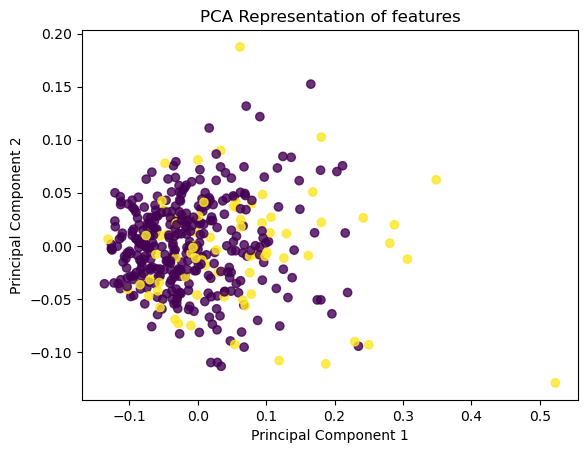

In [10]:
from sklearn.decomposition import PCA

# Perform PCA on features
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(features)

# Plot the PCA result
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=meta_dat['unfavorable'], alpha=0.8)
plt.title('PCA Representation of features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [11]:
print(pca.explained_variance_ratio_)

[0.5293647  0.13417237]


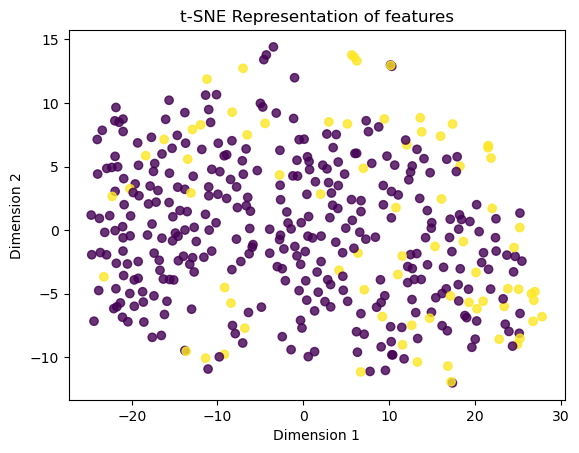

In [12]:
# Perform t-SNE on features
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=meta_dat['unfavorable'], alpha=0.8)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=meta_dat['y_pred_class'], alpha=0.8)
plt.title('t-SNE Representation of features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


c:\Users\brdd\.conda\envs\xai\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\brdd\.conda\envs\xai\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\brdd\.conda\envs\xai\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The '

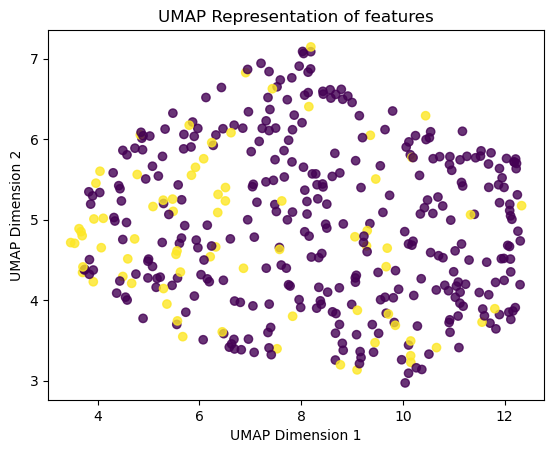

In [13]:
import umap

# Perform UMAP on features
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(features)

# Plot the UMAP result
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=meta_dat['unfavorable'], alpha=0.8)
plt.title('UMAP Representation of features')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


In [14]:
from matplotlib.patches import Rectangle

def min_max_norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Compute the coordinates of the image on the plot
# adapted from https://learnopencv.com/t-sne-for-feature-visualization/
def compute_plot_coordinates(image, x, y):
    image_height, image_width, _ = image.shape
 
    # compute the image center coordinates on the plot
    center_x = x
 
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = y
 
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    # tl_x = center_x - int(image_width / 2)
    # tl_y = center_y - int(image_height / 2)
    tl_x = center_x
    tl_y = center_y
 
    br_x = tl_x + image_width
    br_y = tl_y + image_height
 
    return tl_x, tl_y, br_x, br_y

# adapted from: https://stackoverflow.com/questions/43261338/adding-a-border-to-and-image-in-my-code
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb or rgba array
        framed_img = np.zeros((b+ny+b, b+nx+b, img.shape[2]))
    elif img.ndim == 2: # grayscale image
        framed_img = np.zeros((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return framed_img

def plot_image_on_represantion(dim_red_result, maps, meta_info = None,
                               yx_ratio = 1,
                               im_size = 128*20, map_col = "jet", alpha = 0.8):

    dim_red_result[:, 0] = min_max_norm(dim_red_result[:, 0])
    dim_red_result[:, 1] = min_max_norm(dim_red_result[:, 1])

    dim_red_result = (dim_red_result * (im_size - 128)).astype(int)
    if yx_ratio != 1:
        dim_red_result[:, 0] = (dim_red_result[:, 0] * yx_ratio).astype(int)

    # image = (min_max_norm(mid_maps) * 255).astype(int)
    if np.min(maps) < 0:
        image = ((maps+1)/2 * 255).astype(int)
    else:
        image = (maps * 255).astype(int)

    # plot   

    for i in tqdm(range(dim_red_result.shape[0])):
        im = image[i]
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(im, dim_red_result[i, 0], dim_red_result[i, 1])

        plt.imshow(im, extent=(tl_x, br_x, tl_y, br_y), cmap=map_col, alpha = alpha, vmin = 0, vmax = 255)

        if meta_info is not None:
            rect = Rectangle((tl_x, tl_y), im.shape[0], im.shape[1], angle=0.0,
                  edgecolor = ("green", "red")[meta_info[i]], linewidth=2, facecolor='none', alpha = alpha*0.5)
            plt.gca().add_patch(rect)

    plt.scatter(dim_red_result[:, 0], dim_red_result[:, 1], s=0.01)

    plt.axis('off')
    plt.show()

100%|██████████| 407/407 [00:00<00:00, 577.70it/s]


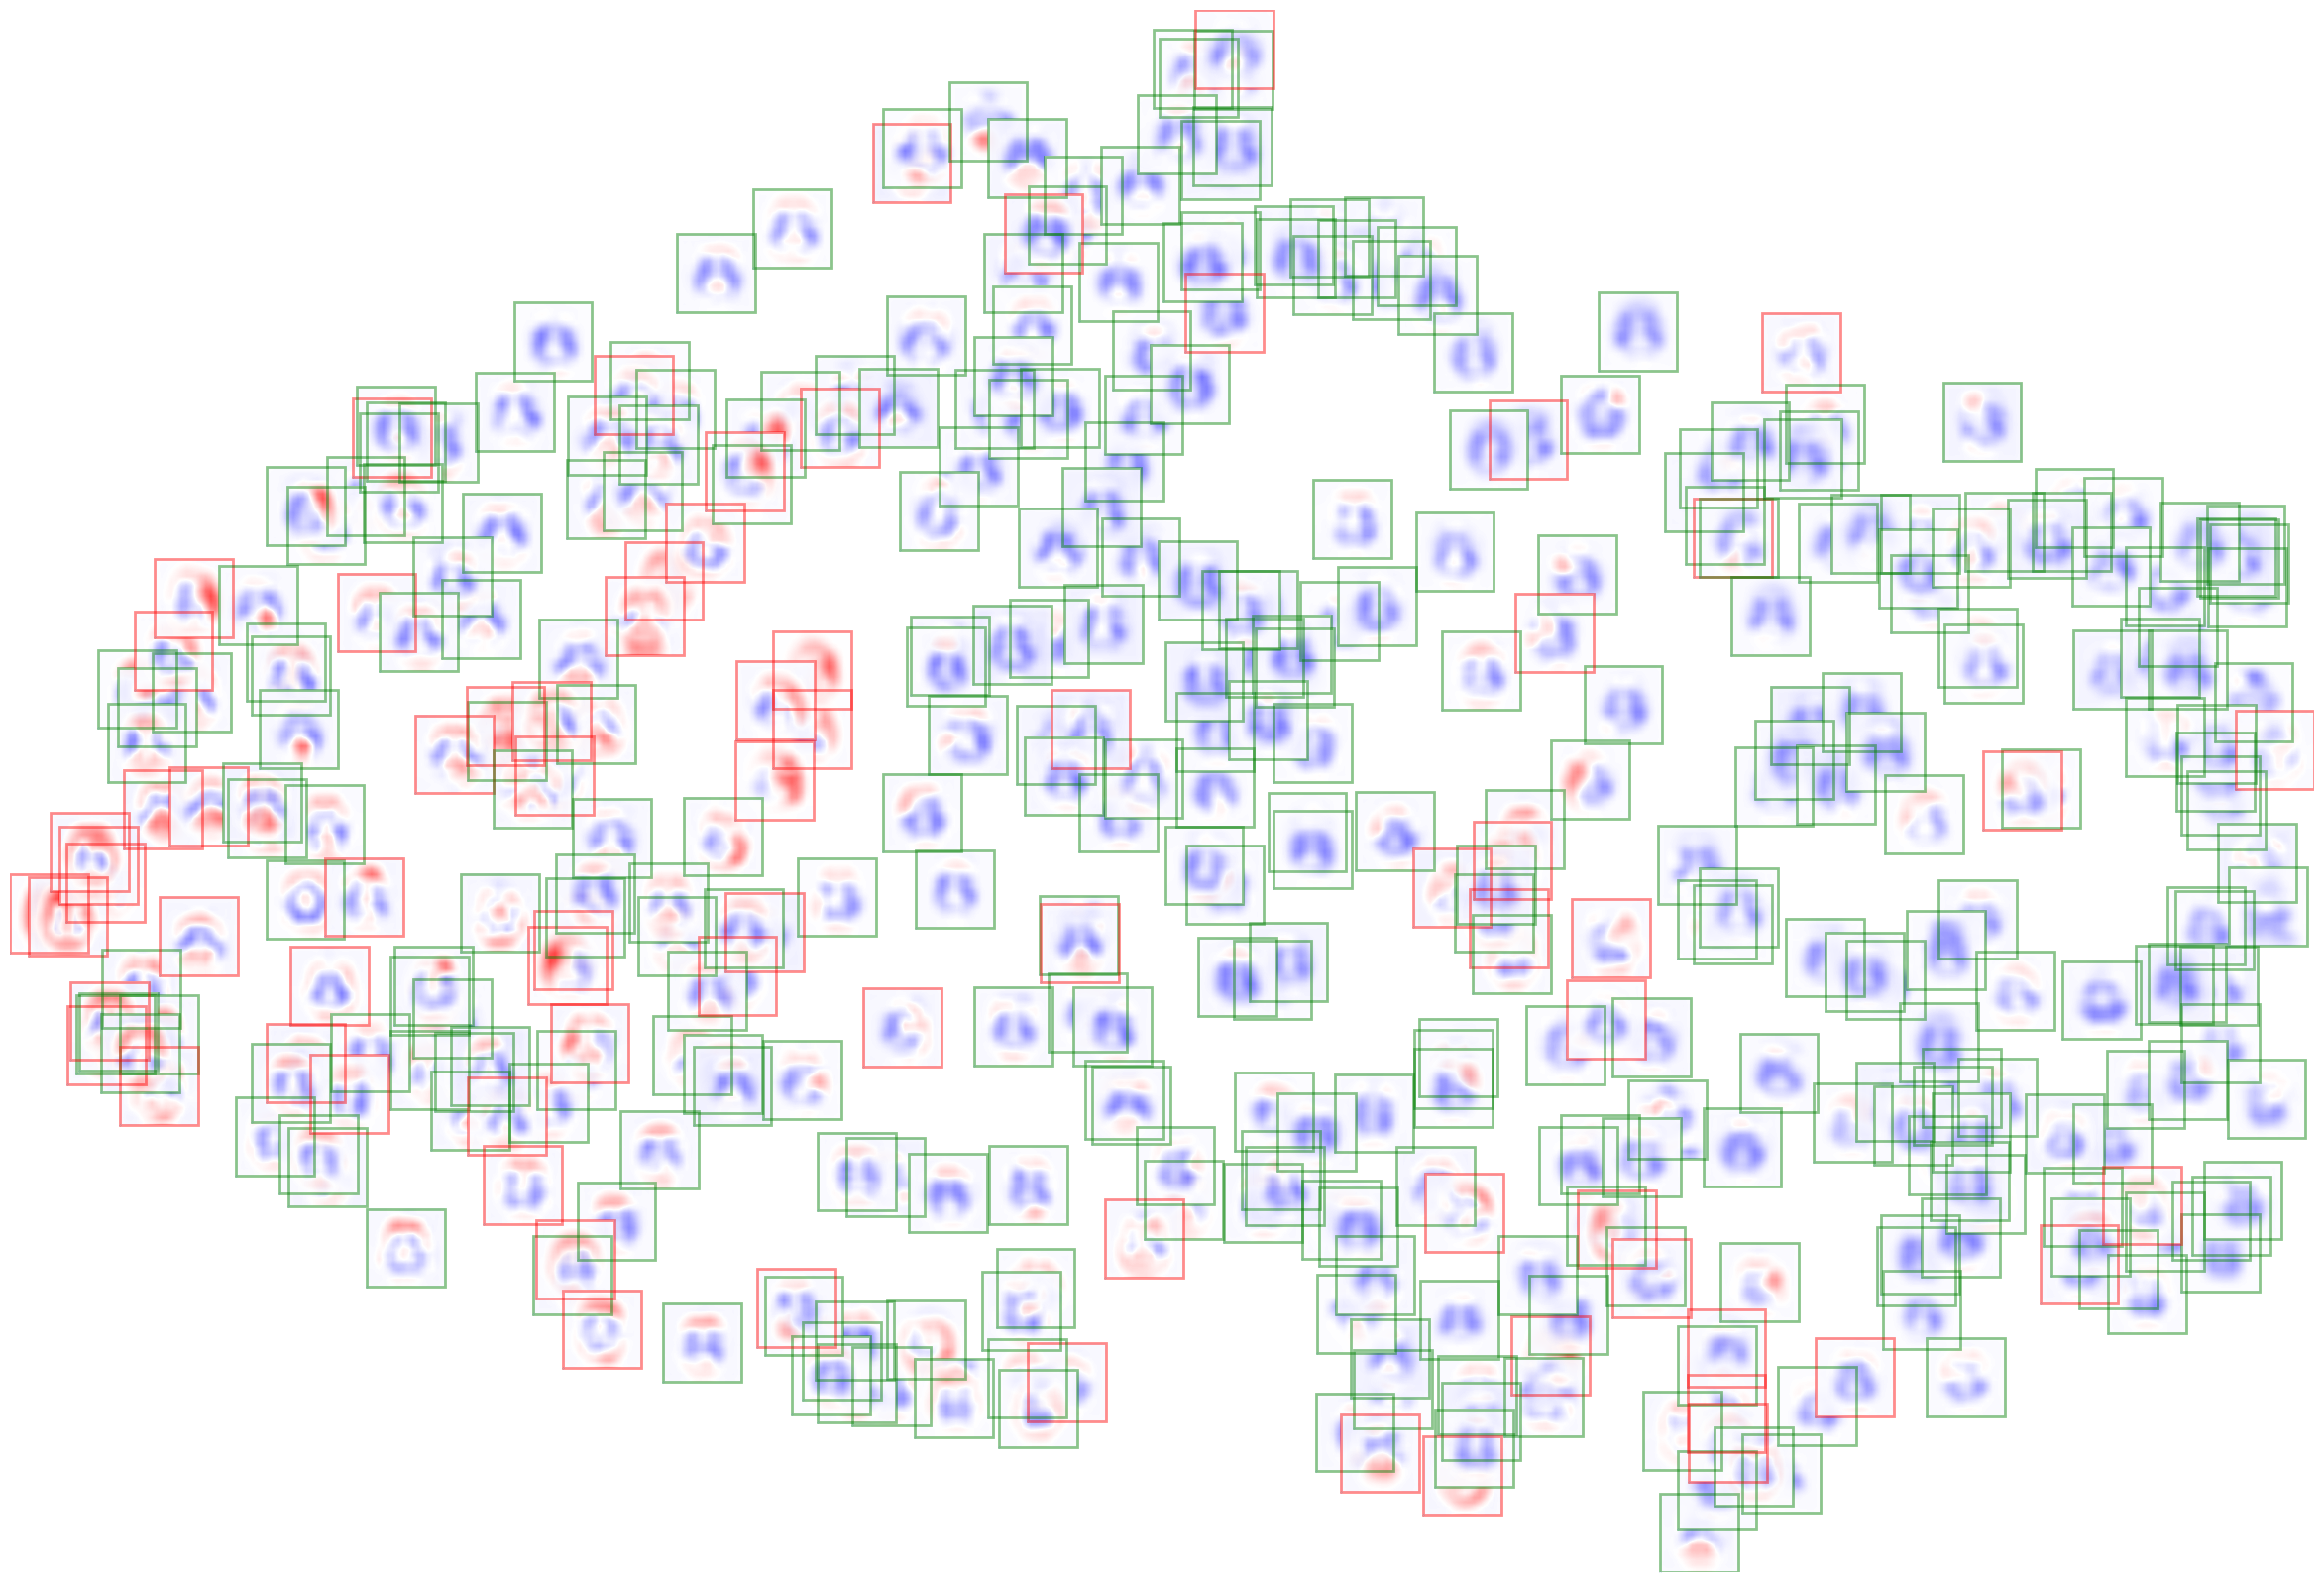

In [18]:
plt.figure(figsize=(30, 30))
# plt.style.use('dark_background')
plt.style.use('default')

plot_image_on_represantion(umap_result, heatmaps_avg, 
                           list(meta_dat['unfavorable']),
                           yx_ratio = 1.5,
                           im_size = 128*20, map_col = "bwr", alpha = 0.7

c:\Users\brdd\.conda\envs\xai\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\brdd\.conda\envs\xai\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\brdd\.conda\envs\xai\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\brdd\.conda\envs\xai\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a m

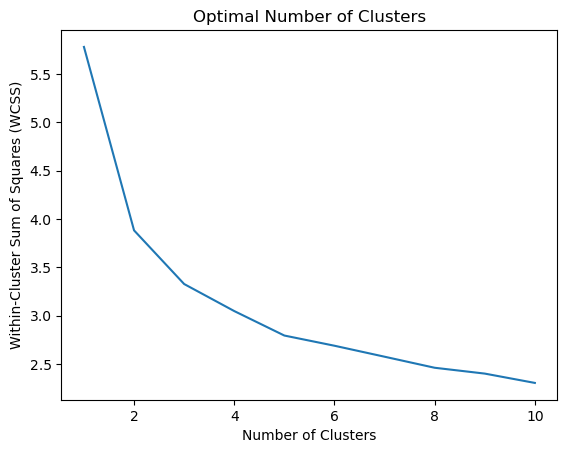

In [16]:
# Find the optimal number of clusters using the elbow method
wcss = []
max_clusters = 10  # Maximum number of clusters to consider
for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

# Plot the within-cluster sum of squares (WCSS) against the number of clusters
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()
